# Planar data classification with one hidden layer

- Implement a 2-class classification neural network with a single hidden layer
- Use units with a non-linear activation function, such as tanh
- Compute the cross entropy loss
- Implement forward and backward propagation


## Table of Contents
- [1 - Packages](#1)
- [2 - Load the Dataset](#2)
    - [Exercise 1](#ex-1)
- [3 - Simple Logistic Regression](#3)
- [4 - Neural Network model](#4)
    - [4.1 - Defining the neural network structure](#4-1)
        - [Exercise 2 - layer_sizes](#ex-2)
    - [4.2 - Initialize the model's parameters](#4-2)
        - [Exercise 3 - initialize_parameters](#ex-3)
    - [4.3 - The Loop](#4-3)
        - [Exercise 4 - forward_propagation](#ex-4)
    - [4.4 - Compute the Cost](#4-4)
        - [Exercise 5 - compute_cost](#ex-5)
    - [4.5 - Implement Backpropagation](#4-5)
        - [Exercise 6 - backward_propagation](#ex-6)
    - [4.6 - Update Parameters](#4-6)
        - [Exercise 7 - update_parameters](#ex-7)
    - [4.7 - Integration](#4-7)
        - [Exercise 8 - nn_model](#ex-8)
- [5 - Test the Model](#5)
    - [5.1 - Predict](#5-1)
        - [Exercise 9 - predict](#ex-9)
    - [5.2 - Test the Model on the Planar Dataset](#5-2)
- [6 - Tuning hidden layer size (optional/ungraded exercise)](#6)
- [7- Performance on other datasets](#7)

<a name='1'></a>
# 1 - Packages

First import all the packages that you will need during this assignment.

- [numpy](https://www.numpy.org/) is the fundamental package for scientific computing with Python.
- [sklearn](http://scikit-learn.org/stable/) provides simple and efficient tools for data mining and data analysis. 
- [matplotlib](http://matplotlib.org) is a library for plotting graphs in Python.
- testCases provides some test examples to assess the correctness of your functions
- planar_utils provide various useful functions used in this assignment

In [1]:
# Package imports
import numpy as np
import copy
import matplotlib.pyplot as plt
from testCases_v2 import *
from public_tests import *
import sklearn
import sklearn.datasets
import sklearn.linear_model
from planar_utils import plot_decision_boundary, sigmoid, load_planar_dataset, load_extra_datasets

%matplotlib inline

%load_ext autoreload
%autoreload 2

<a name='2'></a>
# 2 - Load the Dataset 

Now, load the dataset you'll be working on. The following code will load a "flower" 2-class dataset into variables X and Y.

In [2]:
X, Y = load_planar_dataset()

Visualize the dataset using matplotlib. The data looks like a "flower" with some red (label y=0) and some blue (y=1) points. Your goal is to build a model to fit this data. In other words, we want the classifier to define regions as either red or blue.

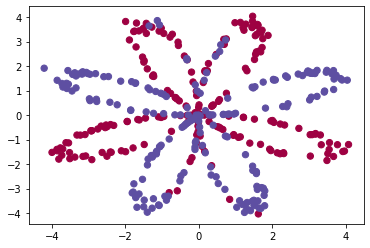

In [6]:
# Visualize the data:
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral);

In [11]:
shape_X= X.shape
shape_Y= Y.shape
m= X.shape[1]

print ('The shape of X is: ' + str(shape_X))
print ('The shape of Y is: ' + str(shape_Y))
print ('I have m = %d training examples!' % (m))

The shape of X is: (2, 400)
The shape of Y is: (1, 400)
I have m = 400 training examples!


**Expected Output**:
       
<table style="width:20%">
  <tr>
    <td> shape of X </td>
    <td> (2, 400) </td> 
  </tr>
  <tr>
    <td>shape of Y</td>
    <td>(1, 400) </td> 
    </tr>
    <tr>
    <td>m</td>
    <td> 400 </td> 
  </tr>
</table>

<a name='3'></a>
## 3 - Simple Logistic Regression

Before building a full neural network, let's check how logistic regression performs on this problem. You can use sklearn's built-in functions for this. Run the code below to train a logistic regression classifier on the dataset.

In [12]:
# Train the logistic regression classifier
clf = sklearn.linear_model.LogisticRegressionCV();
clf.fit(X.T, Y.T);

You can now plot the decision boundary of these models! Run the code below.

Accuracy of logistic regression: 47 % (percentage of correctly labelled datapoints)


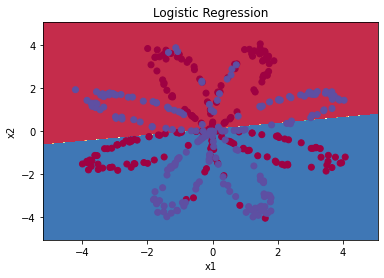

In [13]:
# Plot the decision boundary for logistic regression
plot_decision_boundary(lambda x: clf.predict(x), X, Y)
plt.title("Logistic Regression")

# Print accuracy
LR_predictions = clf.predict(X.T)
print ('Accuracy of logistic regression: %d ' % float((np.dot(Y,LR_predictions) + np.dot(1-Y,1-LR_predictions))/float(Y.size)*100) +
       '% ' + "(percentage of correctly labelled datapoints)")

**Expected Output**:

<table style="width:20%">
  <tr>
    <td>Accuracy</td>
    <td> 47% </td> 
  </tr>
  
</table>


**Interpretation**: The dataset is not linearly separable, so logistic regression doesn't perform well. Hopefully a neural network will do better. Let's try this now! 

<a name='4'></a>
## 4 - Neural Network model

Logistic regression didn't work well on the flower dataset. Next, you're going to train a Neural Network with a single hidden layer and see how that handles the same problem.

**The model**:
<img src="images/classification_kiank.png" style="width:600px;height:300px;">

**Mathematically**:

For one example $x^{(i)}$:
$$z^{[1] (i)} =  W^{[1]} x^{(i)} + b^{[1]}\tag{1}$$ 
$$a^{[1] (i)} = \tanh(z^{[1] (i)})\tag{2}$$
$$z^{[2] (i)} = W^{[2]} a^{[1] (i)} + b^{[2]}\tag{3}$$
$$\hat{y}^{(i)} = a^{[2] (i)} = \sigma(z^{ [2] (i)})\tag{4}$$
$$y^{(i)}_{prediction} = \begin{cases} 1 & \mbox{if } a^{[2](i)} > 0.5 \\ 0 & \mbox{otherwise } \end{cases}\tag{5}$$

Given the predictions on all the examples, you can also compute the cost $J$ as follows: 
$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large\left(\small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right)  \large  \right) \small \tag{6}$$

**Reminder**: The general methodology to build a Neural Network is to:
    1. Define the neural network structure ( # of input units,  # of hidden units, etc). 
    2. Initialize the model's parameters
    3. Loop:
        - Implement forward propagation
        - Compute loss
        - Implement backward propagation to get the gradients
        - Update parameters (gradient descent)

In practice, you'll often build helper functions to compute steps 1-3, then merge them into one function called `nn_model()`. Once you've built `nn_model()` and learned the right parameters, you can make predictions on new data.

<a name='4-1'></a>
### 4.1 - Defining the neural network structure ####

<a name='ex-2'></a>
### Exercise 2 - layer_sizes 

Define three variables:
    - n_x: the size of the input layer
    - n_h: the size of the hidden layer (set this to 4) 
    - n_y: the size of the output layer

In [14]:
# GRADED FUNCTION: layer_sizes

def layer_sizes(X, Y):
    """
    Arguments:
    X -- input dataset of shape (input size, number of examples)
    Y -- labels of shape (output size, number of examples)
    
    Returns:
    n_x -- the size of the input layer
    n_h -- the size of the hidden layer
    n_y -- the size of the output layer
    """
    n_x= X.shape[0]
    n_h= 4
    n_y= Y.shape[0]
    
    return (n_x, n_h, n_y)

In [15]:
(n_x, n_h, n_y) = layer_sizes(t_X, t_Y)
print("The size of the input layer is: n_x = " + str(n_x))
print("The size of the hidden layer is: n_h = " + str(n_h))
print("The size of the output layer is: n_y = " + str(n_y))


The size of the input layer is: n_x = 5
The size of the hidden layer is: n_h = 4
The size of the output layer is: n_y = 2
All tests passed!


***Expected output***
```
The size of the input layer is: n_x = 5
The size of the hidden layer is: n_h = 4
The size of the output layer is: n_y = 2
```

<a name='4-2'></a>
### 4.2 - Initialize the model's parameters ####

<a name='ex-3'></a>
### Exercise 3 -  initialize_parameters

Implement the function `initialize_parameters()`.



In [22]:
# GRADED FUNCTION: initialize_parameters

def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    params -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """    
   
    W1 = np.random.rand(n_h,n_x)* 0.01
    b1 = np.zeros((n_h,1))
    W2 = np.random.rand(n_y,n_h) * 0.01
    b2 = np.zeros((n_y,1))
    
    

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [ ]:
np.random.seed(2)

parameters = initialize_parameters(n_x, n_h, n_y)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))



**Expected output**
```
W1 = [[-0.00416758 -0.00056267]
 [-0.02136196  0.01640271]
 [-0.01793436 -0.00841747]
 [ 0.00502881 -0.01245288]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[-0.01057952 -0.00909008  0.00551454  0.02292208]]
b2 = [[0.]]
```

<a name='4-3'></a>
### 4.3 - The Loop 

<a name='ex-4'></a>
### Exercise 4 - forward_propagation

Implement `forward_propagation()` using the following equations:

$$Z^{[1]} =  W^{[1]} X + b^{[1]}\tag{1}$$ 
$$A^{[1]} = \tanh(Z^{[1]})\tag{2}$$
$$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}\tag{3}$$
$$\hat{Y} = A^{[2]} = \sigma(Z^{[2]})\tag{4}$$




In [48]:
# GRADED FUNCTION:forward_propagation

def forward_propagation(X, parameters):
    """
    Argument:
    X -- input data of size (n_x, m)
    parameters -- python dictionary containing your parameters (output of initialization function)
    
    Returns:
    A2 -- The sigmoid output of the second activation
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2"
    """
    
    W1=parameters["W1"]
    b1=parameters["b1"]
    W2=parameters["W2"]
    b2=parameters["b2"]
    
    
    Z1= np.dot(W1, X)+ b1
    A1= np.tanh(Z1)
    Z2= np.dot(W2, A1)+b2
    A2= 1/ (1+ np.exp(-(Z2)))
    
    
    assert(A2.shape == (1, X.shape[1]))
    
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

In [49]:

A2, cache = forward_propagation(t_X, parameters)
print("A2 = " + str(A2))


A2 = [[0.21292656 0.21274673 0.21295976]]
All tests passed!


***Expected output***
```
A2 = [[0.21292656 0.21274673 0.21295976]]
```

<a name='4-4'></a>
### 4.4 - Compute the Cost

Now that you've computed $A^{[2]}$ (in the Python variable "`A2`"), which contains $a^{[2](i)}$ for all examples, you can compute the cost function as follows:

$$J = - \frac{1}{m} \sum\limits_{i = 1}^{m} \large{(} \small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right) \large{)} \small\tag{13}$$

<a name='ex-5'></a>
### Exercise 5 - compute_cost 

Implement `compute_cost()` to compute the value of the cost $J$.


In [52]:
# GRADED FUNCTION: compute_cost

def compute_cost(A2, Y):
    """
    Computes the cross-entropy cost given in equation (13)
    
    Arguments:
    A2 -- The sigmoid output of the second activation, of shape (1, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost given equation (13)
    
    """
    
    m = Y.shape[1] # number of examples

    cost = np.sum(-(np.dot(Y,np.log(A2).T)+np.dot(1-Y,np.log(1-A2).T)))/m 
    
    cost = float(np.squeeze(cost))  # makes sure cost is the dimension we expect. 
                                    # E.g., turns [[17]] into 17 
    
    return cost

In [53]:
cost = compute_cost(A2, t_Y)
print("cost = " + str(compute_cost(A2, t_Y)))



cost = 0.6930587610394646
All tests passed!


***Expected output***

`cost = 0.6930587610394646`


<a name='4-5'></a>
### 4.5 - Implement Backpropagation

Using the cache computed during forward propagation, you can now implement backward propagation.

<a name='ex-6'></a>
### Exercise 6 -  backward_propagation

Implement the function `backward_propagation()`.



In [58]:
# GRADED FUNCTION: backward_propagation

def backward_propagation(parameters, cache, X, Y):
    """
    Implement the backward propagation using the instructions above.
    
    Arguments:
    parameters -- python dictionary containing our parameters 
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2".
    X -- input data of shape (2, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    
    Returns:
    grads -- python dictionary containing your gradients with respect to different parameters
    """
    m = X.shape[1]
    
    W1=parameters["W1"]
    b1=parameters["b1"]
    W2=parameters["W2"]
    b2=parameters["b2"]
    
    Z1= np.dot(W1, X)+ b1
    A1= np.tanh(Z1)
    Z2= np.dot(W2, A1)+b2
    A2= 1/ (1+ np.exp(-(Z2)))
    
    dZ2 = A2 - Y
    dW2 = np.dot(dZ2,A1.T)/m
    db2 = np.sum(dZ2, axis=1, keepdims=True)/m
    dZ1 = np.dot(W2.T, dZ2) * (1 - np.power(A1, 2))
    dW1 = np.dot(dZ1,X.T)/m
    db1 = np.sum(dZ1, axis=1, keepdims=True)/m
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

In [ ]:

grads = backward_propagation(parameters, cache, t_X, t_Y)
print ("dW1 = "+ str(grads["dW1"]))
print ("db1 = "+ str(grads["db1"]))
print ("dW2 = "+ str(grads["dW2"]))
print ("db2 = "+ str(grads["db2"]))


***Expected output***
```
dW1 = [[ 0.00301023 -0.00747267]
 [ 0.00257968 -0.00641288]
 [-0.00156892  0.003893  ]
 [-0.00652037  0.01618243]]
db1 = [[ 0.00176201]
 [ 0.00150995]
 [-0.00091736]
 [-0.00381422]]
dW2 = [[ 0.00078841  0.01765429 -0.00084166 -0.01022527]]
db2 = [[-0.16655712]]
```

<a name='4-6'></a>
### 4.6 - Update Parameters 

<a name='ex-7'></a>
### Exercise 7 - update_parameters

Implement the update rule. Use gradient descent. You have to use (dW1, db1, dW2, db2) in order to update (W1, b1, W2, b2).



In [65]:
# GRADED FUNCTION: update_parameters

def update_parameters(parameters, grads, learning_rate = 1.2):
    """
    Updates parameters using the gradient descent update rule given above
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients 
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    """
   
    W1=parameters["W1"]
    b1=parameters["b1"]
    W2=parameters["W2"]
    b2=parameters["b2"]
    
    # Update rule for each parameter
    W1 = W1 - learning_rate* grads["dW1"]
    b1 = b1 - learning_rate* grads["db1"]
    W2 = W2 - learning_rate* grads["dW2"]
    b2 = b2 - learning_rate* grads["db2"]
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [66]:
parameters = update_parameters(parameters, grads)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[-0.00643025  0.01936718]
 [-0.02410458  0.03978052]
 [-0.01653973 -0.02096177]
 [ 0.01046864 -0.05990141]]
b1 = [[-1.02420756e-06]
 [ 1.27373948e-05]
 [ 8.32996807e-07]
 [-3.20136836e-06]]
W2 = [[-0.01041081 -0.04463285  0.01758031  0.04747113]]
b2 = [[0.00010457]]
All tests passed!


In [62]:
print(grads)

{'dW1': array([[ 0.00023322, -0.00205423],
       [ 0.00082222, -0.00700776],
       [-0.00031831,  0.0028636 ],
       [-0.00092857,  0.00809933]]), 'dW2': array([[-1.75740039e-05,  3.70231337e-03, -1.25683095e-03,
        -2.55715317e-03]]), 'db1': array([[ 1.05570087e-07],
       [-3.81814487e-06],
       [-1.90155145e-07],
       [ 5.46467802e-07]]), 'db2': array([[-1.0892314e-05]])}


***Expected output***
```
W1 = [[-0.00643025  0.01936718]
 [-0.02410458  0.03978052]
 [-0.01653973 -0.02096177]
 [ 0.01046864 -0.05990141]]
b1 = [[-1.02420756e-06]
 [ 1.27373948e-05]
 [ 8.32996807e-07]
 [-3.20136836e-06]]
W2 = [[-0.01041081 -0.04463285  0.01758031  0.04747113]]
b2 = [[0.00010457]]
```

<a name='4-7'></a>
### 4.7 - Integration

Integrate your functions in `nn_model()` 

<a name='ex-8'></a>
### Exercise 8 - nn_model

Build your neural network model in `nn_model()`.

**Instructions**: The neural network model has to use the previous functions in the right order.

In [67]:
# GRADED FUNCTION: nn_model

def nn_model(X, Y, n_h, num_iterations = 10000, print_cost=False):
    """
    Arguments:
    X -- dataset of shape (2, number of examples)
    Y -- labels of shape (1, number of examples)
    n_h -- size of the hidden layer
    num_iterations -- Number of iterations in gradient descent loop
    print_cost -- if True, print the cost every 1000 iterations
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    np.random.seed(3)
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]
    
    parameters = initialize_parameters(n_x, n_h, n_y)
    # Loop (gradient descent)

    for i in range(0, num_iterations):
    
        A2, cache = forward_propagation(X, parameters)
        
        cost = compute_cost(A2, Y)
 
        grads = backward_propagation(parameters, cache, X, Y)
 
        parameters = update_parameters(parameters, grads)
        
        # Print the cost every 1000 iterations
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    return parameters

In [ ]:
parameters = nn_model(t_X, t_Y, 4, num_iterations=10000, print_cost=True)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))


***Expected output***
```
Cost after iteration 0: 0.693198
Cost after iteration 1000: 0.000219
Cost after iteration 2000: 0.000108
...
Cost after iteration 8000: 0.000027
Cost after iteration 9000: 0.000024
W1 = [[ 0.56305445 -1.03925886]
 [ 0.7345426  -1.36286875]
 [-0.72533346  1.33753027]
 [ 0.74757629 -1.38274074]]
b1 = [[-0.22240654]
 [-0.34662093]
 [ 0.33663708]
 [-0.35296113]]
W2 = [[ 1.82196893  3.09657075 -2.98193564  3.19946508]]
b2 = [[0.21344644]]
```

<a name='5'></a>
## 5 - Test the Model

<a name='5-1'></a>
### 5.1 - Predict

<a name='ex-9'></a>
### Exercise 9 - predict

Predict with your model by building `predict()`.
Use forward propagation to predict results.

**Reminder**: predictions = $y_{prediction} = \mathbb 1 \text{{activation > 0.5}} = \begin{cases}
      1 & \text{if}\ activation > 0.5 \\
      0 & \text{otherwise}
    \end{cases}$  
    


In [71]:
# GRADED FUNCTION: predict

def predict(parameters, X):
    """
    Using the learned parameters, predicts a class for each example in X
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (n_x, m)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    
    A2, cache = forward_propagation(X, parameters)
    predictions = (A2>0.5)
    
    return predictions

In [72]:
predictions = predict(parameters, t_X)
print("Predictions: " + str(predictions))


Predictions: [[ True False  True]]
All tests passed!


***Expected output***
```
Predictions: [[ True False  True]]
```

<a name='5-2'></a>
### 5.2 - Test the Model on the Planar Dataset

It's time to run the model and see how it performs on a planar dataset. Run the following code to test your model with a single hidden layer of $n_h$ hidden units!

Cost after iteration 0: 0.693154
Cost after iteration 1000: 0.283812
Cost after iteration 2000: 0.270343
Cost after iteration 3000: 0.262768
Cost after iteration 4000: 0.255385
Cost after iteration 5000: 0.226697
Cost after iteration 6000: 0.221920
Cost after iteration 7000: 0.219109
Cost after iteration 8000: 0.217044
Cost after iteration 9000: 0.215391


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 4')

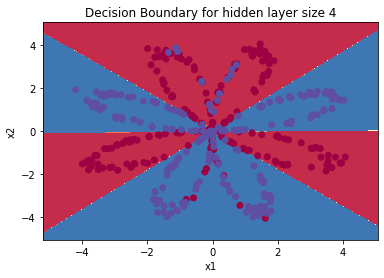

In [73]:
# Build a model with a n_h-dimensional hidden layer
parameters = nn_model(X, Y, n_h = 4, num_iterations = 10000, print_cost=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(4))

In [74]:
# Print accuracy
predictions = predict(parameters, X)
print ('Accuracy: %d' % float((np.dot(Y, predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size) * 100) + '%')

Accuracy: 90%


**Expected Output**: 

<table style="width:30%">
  <tr>
    <td><b>Accuracy</b></td>
    <td> 90% </td> 
  </tr>
</table>

Accuracy is really high compared to Logistic Regression. The model has learned the patterns of the flower's petals! Unlike logistic regression, neural networks are able to learn even highly non-linear decision boundaries. 

### Congrats on finishing this Programming Assignment! 

Here's a quick recap of all you just accomplished: 

- Built a complete 2-class classification neural network with a hidden layer
- Made good use of a non-linear unit
- Computed the cross entropy loss
- Implemented forward and backward propagation
- Seen the impact of varying the hidden layer size, including overfitting.

You've created a neural network that can learn patterns! Excellent work. Below, there are some optional exercises to try out some other hidden layer sizes, and other datasets. 

<a name='6'></a>
## 6 - Tuning hidden layer size (optional/ungraded exercise)

Run the following code(it may take 1-2 minutes). Then, observe different behaviors of the model for various hidden layer sizes.

Accuracy for 1 hidden units: 67.5 %
Accuracy for 2 hidden units: 67.25 %
Accuracy for 3 hidden units: 90.75 %
Accuracy for 4 hidden units: 90.5 %
Accuracy for 5 hidden units: 90.75 %
Accuracy for 20 hidden units: 90.75 %
Accuracy for 50 hidden units: 90.5 %


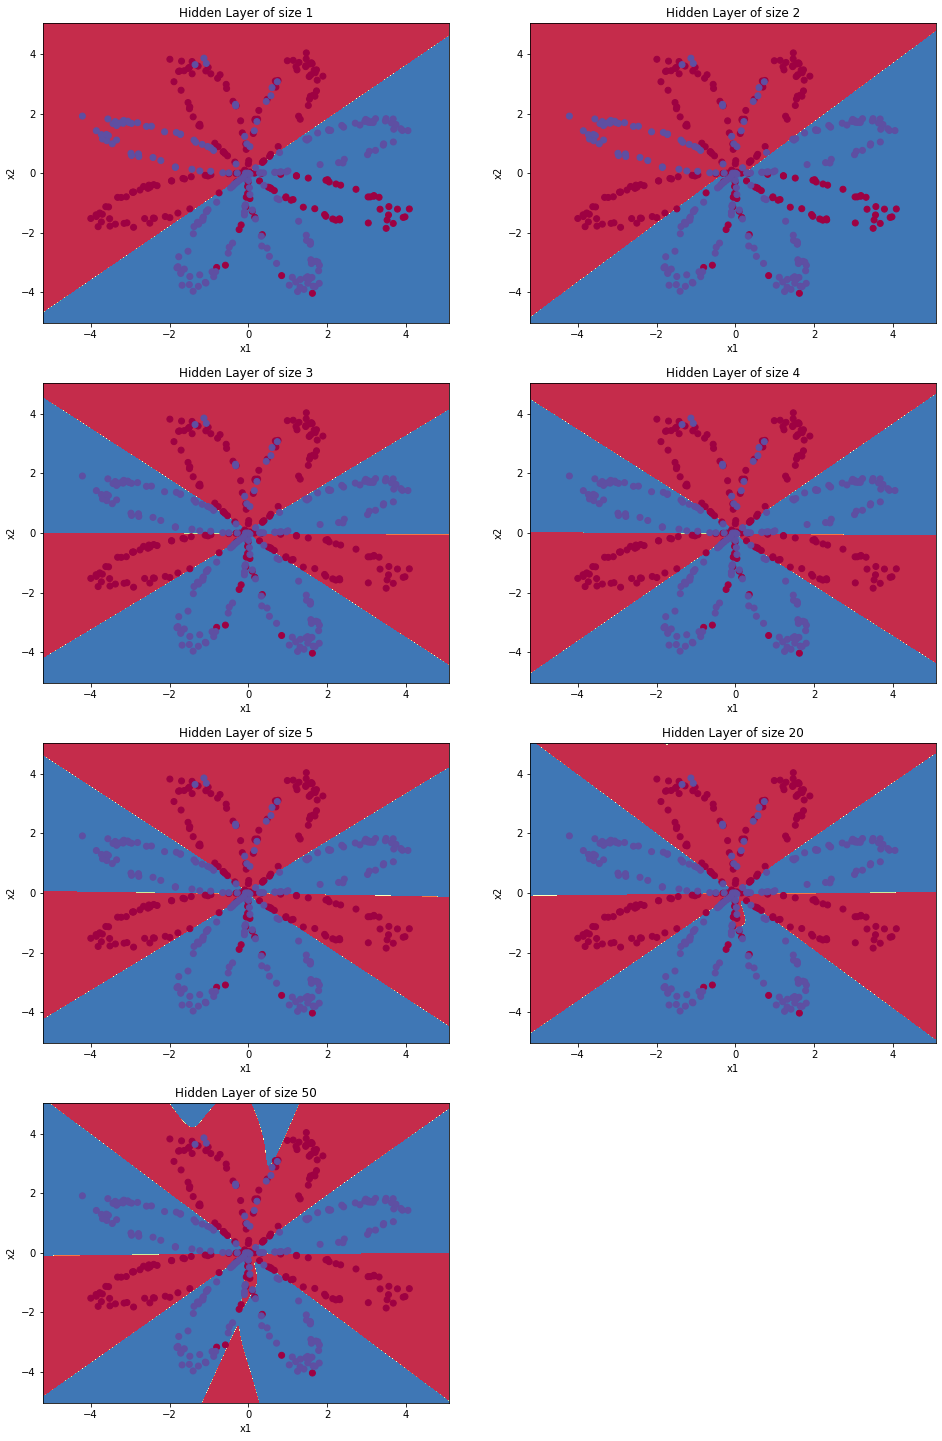

In [75]:
# This may take about 2 minutes to run

plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h, num_iterations = 5000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
    predictions = predict(parameters, X)
    accuracy = float((np.dot(Y,predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))

**Interpretation**:
- The larger models (with more hidden units) are able to fit the training set better, until eventually the largest models overfit the data. 
- The best hidden layer size seems to be around n_h = 5. Indeed, a value around here seems to  fits the data well without also incurring noticeable overfitting.
- Later, you'll become familiar with regularization, which lets you use very large models (such as n_h = 50) without much overfitting. 

**Note**: Remember to submit the assignment by clicking the blue "Submit Assignment" button at the upper-right. 

**Some optional/ungraded questions that you can explore if you wish**: 
- What happens when you change the tanh activation for a sigmoid activation or a ReLU activation?
- Play with the learning_rate. What happens?
- What if we change the dataset? (See part 5 below!)

<a name='7'></a>
## 7- Performance on other datasets

If you want, you can rerun the whole notebook (minus the dataset part) for each of the following datasets.

In [ ]:
# Datasets
noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure = load_extra_datasets()

datasets = {"noisy_circles": noisy_circles,
            "noisy_moons": noisy_moons,
            "blobs": blobs,
            "gaussian_quantiles": gaussian_quantiles}

### START CODE HERE ### (choose your dataset)
dataset = "noisy_moons"
### END CODE HERE ###

X, Y = datasets[dataset]
X, Y = X.T, Y.reshape(1, Y.shape[0])

# make blobs binary
if dataset == "blobs":
    Y = Y%2

# Visualize the data
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral);

**References**:

- http://scs.ryerson.ca/~aharley/neural-networks/
- http://cs231n.github.io/neural-networks-case-study/